In [15]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.optimize import minimize
import torch
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
import sobol_seq
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch.acquisition.multi_objective.logei import qLogExpectedHypervolumeImprovement
from botorch.optim.optimize import optimize_acqf
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning
from botorch.utils.multi_objective.pareto import is_non_dominated
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, MaxAbsScaler
from gpytorch.kernels import RBFKernel, MaternKernel, ScaleKernel

# Load the SciencePlots style for better aesthetics, especially suited for scientific papers
import scienceplots

# Activate 'science' style from SciencePlots for clean, professional-looking plots
plt.style.use(['science', 'nature', 'retro'])

# Error function
def createRandomError(n, std):
    return np.random.normal(loc=1, scale=std, size=n)

# Define the Fractional Maxwell Liquid model (springpot-dashpot)
def FractionalMaxwellLiquidModel(G, eta_s, beta, t, errorInserted=0.00):
    gamma_1_plus_beta = gamma(1 + beta)
    term1 = np.divide(t, eta_s)
    term2 = np.divide(np.power(t, beta), G * gamma_1_plus_beta)
    result = np.add(term1, term2)
    
    if errorInserted != 0:
        error = np.random.normal(1, errorInserted, size=t.shape)
        result = np.multiply(result, error)
        
    return result

# Load rheological data
data = pd.read_csv('./data/polystyrene/creep_ps175_data.csv', delimiter='\t', decimal=".")
time = data['Time'].values
J_creep = data['Creep Compliance'].values

# Objective function to minimize (RRS weighted by true values) - two objectives
def objective(params):
    logG, log_eta_s, beta = params
    G = 10 ** logG
    eta_s = 10 ** log_eta_s
    model_values = FractionalMaxwellLiquidModel(G, eta_s, beta, time)
    rss_error = np.sum(((J_creep - model_values) / J_creep) ** 2)
    # Here we use the same RSS as a placeholder for the second objective, replace it with your actual second objective if different
    obj2 = np.sum(((J_creep - model_values) / 1) ** 2)
    return np.array([-np.log10(rss_error), -np.log10(obj2)])

# Define search space bounds
param_space = np.array([
    [4, 7],  # log10 scale for G
    [4, 7],  # log10 scale for eta_s
    [0, 1.0]   # real scale for beta
])

# Function to create Sobol samples
def sobol_sample(space, n_samples):
    sobol_samples = sobol_seq.i4_sobol_generate(len(space), n_samples)
    sobol_scaled = sobol_samples * (space[:, 1] - space[:, 0]) + space[:, 0]
    return np.array(sobol_scaled)

# Initialize model function for multi-objective problem
def initialize_model(train_x, train_obj):
    models = []
    for i in range(train_obj.shape[-1]):
        train_y = train_obj[..., i:i+1]
        models.append(SingleTaskGP(train_x, train_y, covar_module=MaternKernel(nu=1.5)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    return mll, model

# Compute the qEHVI acquisition function to find new candidate points that maximize objectives
def compute_qehvi_acquisition_function(model, train_x, train_obj, bounds):
    ref_point = torch.max(train_obj, dim=0)[0]  # Ensure it is a tensor
    partitioning = FastNondominatedPartitioning(ref_point=ref_point, Y=train_obj)
    acq_func = qLogExpectedHypervolumeImprovement(
        model=model,
        ref_point=ref_point.tolist(),  # Convert only when necessary
        partitioning=partitioning
    )
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,  # Number of candidates to generate in a batch
        num_restarts=3,
        raw_samples=10,
        options={"batch_limit": 5, "maxiter": 50},
    )
    return candidates

# Initial sampling using Sobol sequence
n_initial_points = 256
X_samples = sobol_sample(param_space, n_initial_points)
y_samples = np.array([objective(x) for x in X_samples])

# Initialize scalers for each objective
scaler_obj1 = StandardScaler()
scaler_obj2 = StandardScaler()

# Reshape the samples for each objective to fit the scalers
y_samples_obj1_scaled = scaler_obj1.fit_transform(y_samples[:, 0].reshape(-1, 1)).flatten()
y_samples_obj2_scaled = scaler_obj2.fit_transform(y_samples[:, 1].reshape(-1, 1)).flatten()

# Stack the scaled objectives
y_samples_scaled = np.vstack((y_samples_obj1_scaled, y_samples_obj2_scaled)).T

# Convert to tensors for BoTorch
X_samples_tensor = torch.tensor(X_samples, dtype=torch.double)
y_samples_tensor = torch.tensor(y_samples_scaled, dtype=torch.double)

# Compute bounds for optimization
bounds = torch.stack([
    torch.tensor(param_space[:, 0], dtype=torch.double),
    torch.tensor(param_space[:, 1], dtype=torch.double)
])

# Initialize and fit the GP model
mll, model = initialize_model(X_samples_tensor, y_samples_tensor)
fit_gpytorch_mll(mll)




/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


SumMarginalLogLikelihood(
  (likelihood): LikelihoodList(
    (likelihoods): ModuleList(
      (0-1): 2 x GaussianLikelihood(
        (noise_covar): HomoskedasticNoise(
          (noise_prior): GammaPrior()
          (raw_noise_constraint): GreaterThan(1.000E-04)
        )
      )
    )
  )
  (model): ModelListGP(
    (models): ModuleList(
      (0-1): 2 x SingleTaskGP(
        (likelihood): GaussianLikelihood(
          (noise_covar): HomoskedasticNoise(
            (noise_prior): GammaPrior()
            (raw_noise_constraint): GreaterThan(1.000E-04)
          )
        )
        (mean_module): ConstantMean()
        (covar_module): MaternKernel(
          (raw_lengthscale_constraint): Positive()
        )
      )
    )
    (likelihood): LikelihoodList(
      (likelihoods): ModuleList(
        (0-1): 2 x GaussianLikelihood(
          (noise_covar): HomoskedasticNoise(
            (noise_prior): GammaPrior()
            (raw_noise_constraint): GreaterThan(1.000E-04)
          )
      

In [16]:
# Identify the final Pareto front points
pareto_mask = is_non_dominated(y_samples_tensor)
pareto_front = y_samples[pareto_mask]

# Exploitation phase using qEHVI
n_exploitation_iter = 50 # Number of iterations
objective_list = []
new_indices = []  # To keep track of new points added during exploitation
objective_values = list(y_samples)

for i in range(n_exploitation_iter):
    new_candidates = compute_qehvi_acquisition_function(model, X_samples_tensor, y_samples_tensor, bounds)
    new_sample = new_candidates.detach().cpu().numpy().reshape(-1)
    new_sample_y = objective(new_sample)

    # Apply scaling to the new y values separately
    new_sample_y_obj1_scaled = scaler_obj1.transform(new_sample_y[0].reshape(-1, 1)).flatten()[0]
    new_sample_y_obj2_scaled = scaler_obj2.transform(new_sample_y[1].reshape(-1, 1)).flatten()[0]
    new_sample_y_scaled = np.array([new_sample_y_obj1_scaled, new_sample_y_obj2_scaled])
    
    # Append the new sample to the samples and objective values
    new_indices.append(len(y_samples))  # Save the index of the new sample
    X_samples = np.vstack([X_samples, new_sample])
    y_samples = np.vstack([y_samples, new_sample_y])
    y_samples_scaled = np.vstack([y_samples_scaled, new_sample_y_scaled])  # Scaled objective values
    
    # Update tensors
    X_samples_tensor = torch.tensor(X_samples, dtype=torch.double)
    y_samples_tensor = torch.tensor(y_samples_scaled, dtype=torch.double)

    # Append the objective value to the list (original scale)
    objective_list.append(new_sample_y)
    objective_values.append(new_sample_y)
    
    # Update the model with the new data
    mll, model = initialize_model(X_samples_tensor, y_samples_tensor)
    fit_gpytorch_mll(mll)
    
    print(f"Exploitation {i + 1}/{n_exploitation_iter} - New sample: {new_sample}, Objective values: {new_sample_y}")




/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


Exploitation 1/50 - New sample: [4.87789196 5.45727277 0.43850393], Objective values: [-1.52819426  3.43828213]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0148], dtype=torch.float64), mean = tensor([0.0162], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0167], dtype=torch.float64), mean = tensor([0.0171], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 2/50 - New sample: [4.9400143  5.45821089 0.47385806], Objective values: [-1.54610836  3.51156526]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0207], dtype=torch.float64), mean = tensor([0.0241], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0237], dtype=torch.float64), mean = tensor([0.0255], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 3/50 - New sample: [4.96718345 5.46106846 0.48938188], Objective values: [-1.58210323  3.47458804]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0227], dtype=torch.float64), mean = tensor([0.0296], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0321], dtype=torch.float64), mean = tensor([0.0345], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 4/50 - New sample: [6.0973554  5.42572949 0.52203746], Objective values: [-2.23025981  3.68256786]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0268], dtype=torch.float64), mean = tensor([0.0365], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0405], dtype=torch.float64), mean = tensor([0.0436], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 5/50 - New sample: [5.54007255 5.46983508 0.8104944 ], Objective values: [-1.83438626  3.72763536]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0350], dtype=torch.float64), mean = tensor([0.0455], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0487], dtype=torch.float64), mean = tensor([0.0526], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 6/50 - New sample: [4.80394486 5.44953458 0.42020007], Objective values: [-1.21804195  3.73072478]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0423], dtype=torch.float64), mean = tensor([0.0540], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0555], dtype=torch.float64), mean = tensor([0.0610], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 7/50 - New sample: [4.75175107 5.45111989 0.38445658], Objective values: [-1.3043926   3.53917801]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0458], dtype=torch.float64), mean = tensor([0.0606], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0743], dtype=torch.float64), mean = tensor([0.0740], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 8/50 - New sample: [5.53062572 5.4819002  0.79555215], Objective values: [-1.8685798  5.0740176]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0538], dtype=torch.float64), mean = tensor([0.0695], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0814], dtype=torch.float64), mean = tensor([0.0826], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 9/50 - New sample: [4.73022941 5.44750708 0.37799802], Objective values: [-1.18103737  3.6669505 ]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0620], dtype=torch.float64), mean = tensor([0.0785], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0890], dtype=torch.float64), mean = tensor([0.0914], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 10/50 - New sample: [4.705834   5.44367812 0.36190544], Objective values: [-1.12291023  3.76315284]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0708], dtype=torch.float64), mean = tensor([0.0878], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0993], dtype=torch.float64), mean = tensor([0.1015], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 11/50 - New sample: [4.69304283 5.43320821 0.34064188], Objective values: [-1.02221989  4.18831101]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0782], dtype=torch.float64), mean = tensor([0.0965], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1109], dtype=torch.float64), mean = tensor([0.1121], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 12/50 - New sample: [4.69393039 5.42632364 0.3101701 ], Objective values: [-1.17287603  4.40583831]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0995], dtype=torch.float64), mean = tensor([0.1102], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1246], dtype=torch.float64), mean = tensor([0.1236], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 13/50 - New sample: [4.66154949 5.42057362 0.36669174], Objective values: [0.36227821 4.71305366]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1021], dtype=torch.float64), mean = tensor([0.1164], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1412], dtype=torch.float64), mean = tensor([0.1361], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 14/50 - New sample: [5.53631582 5.483387   0.79309613], Objective values: [-1.88766553  5.09737503]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1030], dtype=torch.float64), mean = tensor([0.1212], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1454], dtype=torch.float64), mean = tensor([0.1433], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 15/50 - New sample: [6.09714394 5.43630829 0.49745285], Objective values: [-2.28410703  3.3458056 ]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1166], dtype=torch.float64), mean = tensor([0.1325], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1677], dtype=torch.float64), mean = tensor([0.1577], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 16/50 - New sample: [4.67250416 5.4250306  0.3539261 ], Objective values: [-0.30895599  5.79334135]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1322], dtype=torch.float64), mean = tensor([0.1446], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1902], dtype=torch.float64), mean = tensor([0.1724], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 17/50 - New sample: [4.66508213 5.42438744 0.35706058], Objective values: [-0.04448778  5.8987986 ]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1510], dtype=torch.float64), mean = tensor([0.1577], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2046], dtype=torch.float64), mean = tensor([0.1844], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 18/50 - New sample: [4.65688282 5.42169883 0.35922275], Objective values: [0.32291774 5.04607446]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1682], dtype=torch.float64), mean = tensor([0.1705], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2147], dtype=torch.float64), mean = tensor([0.1948], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 19/50 - New sample: [4.65014355 5.41868451 0.36118883], Objective values: [0.21869437 4.52683417]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1821], dtype=torch.float64), mean = tensor([0.1822], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2228], dtype=torch.float64), mean = tensor([0.2043], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 20/50 - New sample: [4.64548486 5.41644493 0.36327694], Objective values: [-0.0831644   4.26300636]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1838], dtype=torch.float64), mean = tensor([0.1879], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2347], dtype=torch.float64), mean = tensor([0.2155], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 21/50 - New sample: [5.54277367 5.48299635 0.79016348], Objective values: [-1.90296127  4.84838102]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1840], dtype=torch.float64), mean = tensor([0.1924], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2381], dtype=torch.float64), mean = tensor([0.2226], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 22/50 - New sample: [6.09849772 5.43268188 0.50453451], Objective values: [-2.2661018   3.44730546]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1856], dtype=torch.float64), mean = tensor([0.1980], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2494], dtype=torch.float64), mean = tensor([0.2336], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 23/50 - New sample: [5.5443265  5.48237229 0.78922992], Objective values: [-1.90513477  4.82435333]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1963], dtype=torch.float64), mean = tensor([0.2085], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2555], dtype=torch.float64), mean = tensor([0.2422], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 24/50 - New sample: [4.64167003 5.41375976 0.36573245], Objective values: [-0.38627214  4.02863724]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1978], dtype=torch.float64), mean = tensor([0.2140], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2662], dtype=torch.float64), mean = tensor([0.2530], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 25/50 - New sample: [5.54595442 5.48193032 0.78863413], Objective values: [-1.90729739  4.80190539]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2083], dtype=torch.float64), mean = tensor([0.2244], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2720], dtype=torch.float64), mean = tensor([0.2615], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 26/50 - New sample: [4.6421639  5.4140464  0.36578808], Objective values: [-0.36338794  4.04775411]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2187], dtype=torch.float64), mean = tensor([0.2347], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2779], dtype=torch.float64), mean = tensor([0.2700], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 27/50 - New sample: [4.64250163 5.41431622 0.36584803], Objective values: [-0.34306373  4.06561073]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2288], dtype=torch.float64), mean = tensor([0.2450], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2835], dtype=torch.float64), mean = tensor([0.2785], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 28/50 - New sample: [4.64238301 5.41426772 0.36612003], Objective values: [-0.35400555  4.05900327]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2386], dtype=torch.float64), mean = tensor([0.2552], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2891], dtype=torch.float64), mean = tensor([0.2869], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 29/50 - New sample: [4.64239908 5.41427208 0.36627076], Objective values: [-0.3570299   4.05764781]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2482], dtype=torch.float64), mean = tensor([0.2653], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2945], dtype=torch.float64), mean = tensor([0.2952], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 30/50 - New sample: [4.64250319 5.41430929 0.36634967], Objective values: [-0.3551861   4.05951709]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2576], dtype=torch.float64), mean = tensor([0.2753], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2998], dtype=torch.float64), mean = tensor([0.3035], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 31/50 - New sample: [4.64247717 5.41425672 0.36648427], Objective values: [-0.36206094  4.05452889]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2667], dtype=torch.float64), mean = tensor([0.2853], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3050], dtype=torch.float64), mean = tensor([0.3117], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 32/50 - New sample: [4.64260908 5.41428851 0.36651483], Objective values: [-0.35912711  4.05667791]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2675], dtype=torch.float64), mean = tensor([0.2904], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3144], dtype=torch.float64), mean = tensor([0.3220], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 33/50 - New sample: [5.54741357 5.4813105  0.78842533], Objective values: [-1.90756138  4.82196355]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2763], dtype=torch.float64), mean = tensor([0.3002], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3193], dtype=torch.float64), mean = tensor([0.3300], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 34/50 - New sample: [4.64273095 5.41416221 0.36656759], Objective values: [-0.36712363  4.04839715]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2759], dtype=torch.float64), mean = tensor([0.3042], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3216], dtype=torch.float64), mean = tensor([0.3365], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 35/50 - New sample: [6.10042105 5.43178397 0.50453221], Objective values: [-2.26217298  3.47297587]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2754], dtype=torch.float64), mean = tensor([0.3081], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3238], dtype=torch.float64), mean = tensor([0.3429], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 36/50 - New sample: [6.10062738 5.43199539 0.50483609], Objective values: [-2.26311723  3.46692136]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2838], dtype=torch.float64), mean = tensor([0.3177], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3284], dtype=torch.float64), mean = tensor([0.3507], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 37/50 - New sample: [4.64271651 5.41392016 0.36672799], Objective values: [-0.3865029   4.03127415]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2921], dtype=torch.float64), mean = tensor([0.3272], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3330], dtype=torch.float64), mean = tensor([0.3586], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 38/50 - New sample: [4.64296027 5.41406281 0.36664905], Objective values: [-0.37273295  4.04193612]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2926], dtype=torch.float64), mean = tensor([0.3321], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3415], dtype=torch.float64), mean = tensor([0.3685], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 39/50 - New sample: [5.54818707 5.48085607 0.78779575], Objective values: [-1.90843141  4.81553447]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3006], dtype=torch.float64), mean = tensor([0.3416], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3458], dtype=torch.float64), mean = tensor([0.3762], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 40/50 - New sample: [4.64316792 5.41402108 0.36661396], Objective values: [-0.37220289  4.0403694 ]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3085], dtype=torch.float64), mean = tensor([0.3510], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3500], dtype=torch.float64), mean = tensor([0.3839], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 41/50 - New sample: [4.64328131 5.41405293 0.3666019 ], Objective values: [-0.36854843  4.04289735]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3163], dtype=torch.float64), mean = tensor([0.3603], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3542], dtype=torch.float64), mean = tensor([0.3915], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 42/50 - New sample: [4.6433963  5.41408712 0.36658612], Objective values: [-0.36462757  4.04562742]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3239], dtype=torch.float64), mean = tensor([0.3697], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3583], dtype=torch.float64), mean = tensor([0.3991], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 43/50 - New sample: [4.64349658 5.41410632 0.36657696], Objective values: [-0.36199731  4.04728655]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3313], dtype=torch.float64), mean = tensor([0.3789], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3623], dtype=torch.float64), mean = tensor([0.4067], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 44/50 - New sample: [4.64355901 5.41410235 0.36659506], Objective values: [-0.36194429  4.04704144]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3386], dtype=torch.float64), mean = tensor([0.3881], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3662], dtype=torch.float64), mean = tensor([0.4141], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 45/50 - New sample: [4.6435906  5.41407808 0.36662621], Objective values: [-0.36387375  4.04525616]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3378], dtype=torch.float64), mean = tensor([0.3916], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3678], dtype=torch.float64), mean = tensor([0.4201], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 46/50 - New sample: [6.10176577 5.43162146 0.50411968], Objective values: [-2.26166084  3.47728271]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3379], dtype=torch.float64), mean = tensor([0.3961], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3754], dtype=torch.float64), mean = tensor([0.4295], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 47/50 - New sample: [5.54894492 5.48031846 0.78721818], Objective values: [-1.90881531  4.82051929]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3379], dtype=torch.float64), mean = tensor([0.4006], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3828], dtype=torch.float64), mean = tensor([0.4389], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 48/50 - New sample: [5.54983665 5.47999387 0.78669827], Objective values: [-1.91008947  4.80639191]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3380], dtype=torch.float64), mean = tensor([0.4050], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3899], dtype=torch.float64), mean = tensor([0.4481], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Exploitation 49/50 - New sample: [5.55047514 5.47976067 0.78623695], Objective values: [-1.91120249  4.79173639]
Exploitation 50/50 - New sample: [4.64384179 5.4138198  0.36663262], Objective values: [-0.37783951  4.0297218 ]


/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3449], dtype=torch.float64), mean = tensor([0.4139], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/u/81/mirandi1/unix/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3933], dtype=torch.float64), mean = tensor([0.4553], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


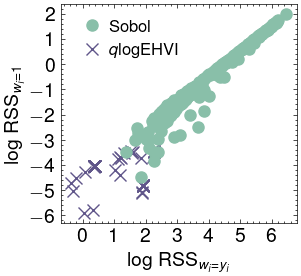

Best parameters from Bayesian Optimization: G = 46246.85, eta_s = 265697.48, beta = 0.36
RSS for the Bayesian Optimization model: 1.10787
Optimized parameters: G = 40928.58, eta_s = 268205.48, beta = 0.36
Optimized Objective (log10): -7.104055500453376
RSS for the final optimized model: 0.87875


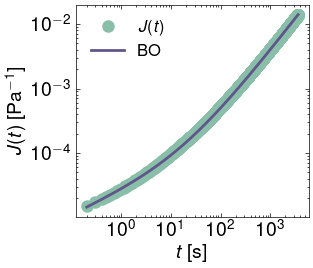

In [42]:
# Highlight new points
new_points_mask = np.zeros(len(y_samples), dtype=bool)
new_points_mask[new_indices] = True

# Plot the final Pareto fronte', 'retro'])

# Error function
def createRandomError(n, std):
    return np.random.normal(loc=1, scale=std, size=n)

# Define the Fractional Maxwell Liquid model (springpot-dashpot)
plt.figure(figsize=(3.0, 2.75), constrained_layout=True)
plt.plot(-y_samples[new_points_mask][:, 0], -y_samples[new_points_mask][:, 1], "x", markersize=8, label='$q$logEHVI', color='#60568A')
plt.plot(-y_samples[~new_points_mask][:, 0], -y_samples[~new_points_mask][:, 1], "o", markersize=8, label='Sobol', color='#89BFA9')
#plt.plot(-pareto_front[:, 0], -pareto_front[:, 1], "x", markersize=8, label='pareto front')
plt.xlabel('$\\log$ RSS$_{w_{i} = y_{i}}$', fontsize=14)
plt.ylabel('$\\log$ RSS$_{w_{i} = 1}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(fontsize=12, loc="best", handletextpad=0.0)  # Adjust handletextpad as needed
# Get current legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Reorder: put 'Sobol' in the second position
order = [1, 0]  # 0 = 'Sobol', 1 = 'qEHVI'

# Apply the new order
plt.legend([handles[i] for i in order], [labels[i] for i in order], fontsize=12, loc="best", handletextpad=0.0)

plt.savefig("fig_qehvi_creep.pdf")
plt.show()

# Extract the best parameters from Bayesian Optimization phase
best_idx = np.argmax(y_samples[:, 0] + y_samples[:, 1])
#best_idx = np.argmax(y_samples[:, 0])
best_params = X_samples[best_idx]
logG_best, log_eta_s_best, beta_best = best_params
G_best_bo = 10 ** logG_best
eta_s_best_bo = 10 ** log_eta_s_best

print("Best parameters from Bayesian Optimization: G = {:.2f}, eta_s = {:.2f}, beta = {:.2f}".format(G_best_bo, eta_s_best_bo, beta_best))

# Fit the model with the best parameters from Bayesian Optimization
bo_model_values = FractionalMaxwellLiquidModel(G_best_bo, eta_s_best_bo, beta_best, time,  errorInserted=0)

# Compute the RSS for the BO model
rss_bo = np.sum(((J_creep - bo_model_values) / J_creep) ** 2)
print(f"RSS for the Bayesian Optimization model: {rss_bo:.5f}")

# Final optimization using scipy.optimize.minimize 
initial_guess = [logG_best, log_eta_s_best, beta_best]

result = minimize(lambda x: -objective(x)[1], initial_guess, bounds=param_space, method='L-BFGS-B')  # Optimize only the first objective for final local optimization
opt_logG, opt_log_eta_s, opt_beta = result.x
opt_G = 10 ** opt_logG
opt_eta_s = 10 ** opt_log_eta_s
opt_objective = result.fun  # Utilize result from minimize directly

print("Optimized parameters: G = {:.2f}, eta_s = {:.2f}, beta = {:.2f}".format(opt_G, opt_eta_s, opt_beta))
print(f"Optimized Objective (log10): {opt_objective}")

# Fit the model with the final optimized parameters
optimal_model_values = FractionalMaxwellLiquidModel(opt_G, opt_eta_s, opt_beta, time, errorInserted=0)

# Compute the RSS for the final optimized model
rss_final = np.sum(((J_creep - optimal_model_values) / J_creep) ** 2)
print(f"RSS for the final optimized model: {rss_final:.5f}")

from cycler import cycler

# Get the default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot the data, the fitted model from Bayesian Optimization, and the final optimized model
plt.figure(figsize=(3.0, 2.75))
plt.plot(time, J_creep, 'o',  color='#89BFA9', markersize=8, label='$J(t)$')
plt.plot(time, bo_model_values, '-', lw=2, color='#60568A', label='BO')
#plt.plot(time, optimal_model_values, '-', lw=2, color=colors[2], label='fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$t$ [s]', fontsize=14)
plt.ylabel('$J(t)$ [Pa$^{-1}$]', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.savefig("fig_mobo_fit_creep_data.pdf")
plt.show()

# Plot the changes in the GP objective values over iterations
#plt.figure(figsize=(12, 6))

#plt.subplot(1, 2, 1)
#plt.plot([x[0] for x in objective_list], label='Objective 1')
#plt.xlabel('Iterations')
#plt.ylabel('log10 RSS')
#plt.title('Objective 1 Over Iterations')
#plt.legend()

#plt.subplot(1, 2, 2)
#plt.plot([x[1] for x in objective_list], label='Objective 2')
#plt.xlabel('Iterations')
#plt.ylabel('Objective 2')
#plt.title('Objective 2 Over Iterations')
#plt.legend()

#plt.tight_layout()
#plt.show()

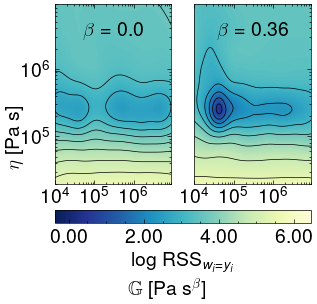

In [67]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

def predict_model_on_grid_2D(model, param_space, beta_value, resolution=100):
    
    # Create a 2D mesh grid over logG and log_eta
    logG_range = torch.linspace(param_space[0, 0], param_space[0, 1], resolution)
    log_eta_range = torch.linspace(param_space[1, 0], param_space[1, 1], resolution)
    
    logG_grid, log_eta_grid = torch.meshgrid(logG_range, log_eta_range, indexing="ij")
    beta_grid = torch.full_like(logG_grid, beta_value)  # keep beta fixed
    
    param_grid = torch.stack([logG_grid.reshape(-1), log_eta_grid.reshape(-1), beta_grid.reshape(-1)], dim=-1)
    
    # Predict using the trained model
    with torch.no_grad():
        preds_1 = model.models[0].posterior(param_grid).mean.numpy().reshape(logG_grid.shape)
    
    return logG_grid, log_eta_grid, preds_1

# Define specific beta values to plot
beta_values = [0.0, 0.36]
resolution = 100

objective_values_1 = first_elements = [arr[0] for arr in objective_values]


# Ensure these values are correctly calculated
min_val, max_val = (-np.max(objective_values_1), -min(objective_values_1))

# Create subplots for each beta value
fig, axes = plt.subplots(1, 2, figsize=(3, 2.75), constrained_layout=True)
contours_list = []
global_minima = []  # To store global minima parameters

for ax, beta in zip(axes.flatten(), beta_values):
    logG_grid, logV_grid, preds_obj1 = predict_model_on_grid_2D(model, param_space, beta, resolution)
    
    # Convert logG and logV to G and V
    G = 10 ** logG_grid.numpy()
    V = 10 ** logV_grid.numpy()

    # Take negative predictions because of the sign inversion
    neg_preds_obj1 = -1 * scaler_obj1.inverse_transform(preds_obj1)
    
    # Find global minima
    min_index = np.unravel_index(neg_preds_obj1.argmin(), neg_preds_obj1.shape)
    global_min_logG = logG_grid[min_index]
    global_min_logV = logV_grid[min_index]
    global_min_G = 10 ** global_min_logG
    global_min_V = 10 ** global_min_logV
    global_min_value = neg_preds_obj1[min_index]
    global_minima.append((global_min_G.item(), global_min_V.item(), 10 ** global_min_value))
    
    # Create the 2D contour plot
    contour = ax.contourf(G, V, neg_preds_obj1, levels=100, vmin=min_val, vmax=max_val, cmap='YlGnBu_r')
    contours_list.append(contour)
    ax.contour(G, V, neg_preds_obj1, levels=10, colors='black', linewidths=0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=14)

    # Set custom axis limits
    ax.set_xlim([1e4, 9e6])   # X-axis limits
    ax.set_ylim([2e4, 9e6])  # Y-axis limits
    
    # Title inside each subplot
    ax.text(0.5, 0.85, f'$\\beta$ = {beta}', fontsize=14, ha='center', va='center', color='black', 
            transform=ax.transAxes)

    # Remove y-axis ticks for second and third subplots
    if ax != axes[0]:
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)

# Add common labels
fig.text(0.5, -0.05, '$\mathbb{G}$ [Pa s$^{\\beta}$]', ha='center', va='center', fontsize=14)
fig.text(-0.01, 0.5, '$\eta$ [Pa s]', ha='center', va='center', rotation='vertical', fontsize=14)

# Create a ScalarMappable for the colorbar
norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
sm = plt.cm.ScalarMappable(cmap='YlGnBu_r', norm=norm)
sm.set_array([])  # Only needed for ScalarMappable


# Add a single colorbar for all subplots
cbar = fig.colorbar(sm, ax=axes, location='bottom', aspect=20, pad=0.02, format='%.2f')
cbar.set_label('$\\log$ RSS$_{w_{i}=y_{i}}$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# Save the plot and show
plt.savefig("fig_obj1_creep_ps.pdf")
plt.show()

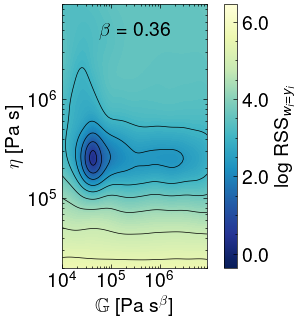

In [68]:
# Plotting
plt.figure(figsize=(3, 3.2), constrained_layout=True)


# 2D contour plot
contour = plt.contourf(G, V, neg_preds_obj1, levels=100, vmin=min_val, vmax=max_val, cmap='YlGnBu_r')
plt.contour(G, V, neg_preds_obj1, levels=10, colors='black', linewidths=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e4, 9e6)
plt.ylim(2e4, 9e6)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$\mathbb{G}$ [Pa s$^{\\beta}$]', fontsize=14)
plt.ylabel('$\eta$ [Pa s]', fontsize=14)

# Title inside the plot
plt.text(0.5, 0.9, r'$\beta = 0.36$', 
         fontsize=14, ha='center', va='center', color='black', 
         transform=plt.gca().transAxes)

# Colorbar
norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
sm = plt.cm.ScalarMappable(cmap='YlGnBu_r', norm=norm)
sm.set_array([])

# Corrected colorbar axis
cbar = plt.colorbar(sm, ax=plt.gca(), location='right', aspect=20, pad=0.12, format='%.1f')
cbar.set_label('$\\log$ RSS$_{w_{i}=y_{i}}$', fontsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.ax.invert_xaxis()

# Save and display
plt.savefig("fig_obj1_creep_ps.pdf")
plt.show()

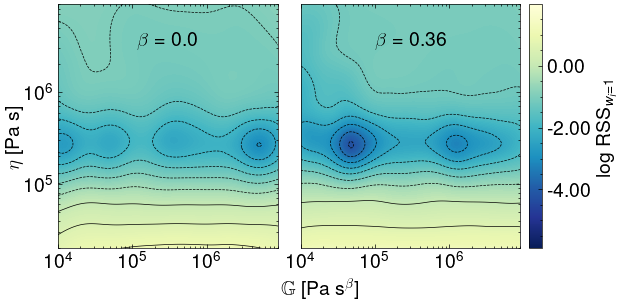

In [69]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

def predict_model_on_grid_2D(model, param_space, beta_value, resolution=100):
    
    # Create a 2D mesh grid over logG and log_eta
    logG_range = torch.linspace(param_space[0, 0], param_space[0, 1], resolution)
    log_eta_range = torch.linspace(param_space[1, 0], param_space[1, 1], resolution)
    
    logG_grid, log_eta_grid = torch.meshgrid(logG_range, log_eta_range, indexing="ij")
    beta_grid = torch.full_like(logG_grid, beta_value)  # keep beta fixed
    
    param_grid = torch.stack([logG_grid.reshape(-1), log_eta_grid.reshape(-1), beta_grid.reshape(-1)], dim=-1)
    
    # Predict using the trained model
    with torch.no_grad():
        preds_2 = model.models[1].posterior(param_grid).mean.numpy().reshape(logG_grid.shape)
    
    return logG_grid, log_eta_grid, preds_2

# Define specific beta values to plot
beta_values = [0.0, 0.36]
resolution = 100

objective_values_2 = first_elements = [arr[1] for arr in objective_values]


# Ensure these values are correctly calculated
min_val, max_val = (-max(objective_values_2), -min(objective_values_2))

# Create subplots for each beta value
fig, axes = plt.subplots(1, 2, figsize=(6, 2.75), constrained_layout=True)
contours_list = []
global_minima = []  # To store global minima parameters

for ax, beta in zip(axes.flatten(), beta_values):
    logG_grid, logV_grid, preds_obj2 = predict_model_on_grid_2D(model, param_space, beta, resolution)
    
    # Convert logG and logV to G and V
    G = 10 ** logG_grid.numpy()
    V = 10 ** logV_grid.numpy()

    # Take negative predictions because of the sign inversion
    neg_preds_obj2 = -1 * scaler_obj2.inverse_transform(preds_obj2)
    
    # Find global minima
    min_index = np.unravel_index(neg_preds_obj2.argmin(), neg_preds_obj2.shape)
    global_min_logG = logG_grid[min_index]
    global_min_logV = logV_grid[min_index]
    global_min_G = 10 ** global_min_logG
    global_min_V = 10 ** global_min_logV
    global_min_value = neg_preds_obj2[min_index]
    global_minima.append((global_min_G.item(), global_min_V.item(), 10 ** global_min_value))
    
    # Create the 2D contour plot
    contour = ax.contourf(G, V, neg_preds_obj2, levels=100, vmin=min_val, vmax=max_val, cmap='YlGnBu_r')
    contours_list.append(contour)
    ax.contour(G, V, neg_preds_obj2, levels=10, colors='black', linewidths=0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=14)

    # Set custom axis limits
    ax.set_xlim([1e4, 9e6])   # X-axis limits
    ax.set_ylim([2e4, 9e6])  # Y-axis limits
    
    # Title inside each subplot
    ax.text(0.5, 0.85, f'$\\beta$ = {beta}', fontsize=14, ha='center', va='center', color='black', 
            transform=ax.transAxes)

    # Remove y-axis ticks for second and third subplots
    if ax != axes[0]:
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)
        
# Create a ScalarMappable for the colorbar
norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
sm = plt.cm.ScalarMappable(cmap='YlGnBu_r', norm=norm)
sm.set_array([])  # Only needed for ScalarMappable

# Add a single colorbar for all subplots
cbar = fig.colorbar(sm, ax=axes, location='right', aspect=20, pad=0.02, format='%.2f')
cbar.set_label('$\\log$ RSS$_{w_{i}=1}$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# Add common labels
fig.text(0.5, -0.05, '$\mathbb{G}$ [Pa s$^{\\beta}$]', ha='center', va='center', fontsize=14)
fig.text(-0.01, 0.5, '$\eta$ [Pa s]', ha='center', va='center', rotation='vertical', fontsize=14)

# Save the plot and show
plt.savefig("fig_obj2_creep_ps.pdf")
plt.show()

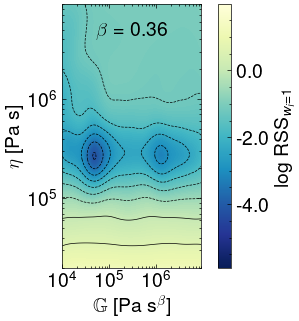

In [71]:
# Plotting
plt.figure(figsize=(3, 3.2), constrained_layout=True)


# 2D contour plot
contour = plt.contourf(G, V, neg_preds_obj2, levels=100, vmin=min_val, vmax=max_val, cmap='YlGnBu_r')
plt.contour(G, V, neg_preds_obj2, levels=10, colors='black', linewidths=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e4, 9e6)
plt.ylim(2e4, 9e6)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$\mathbb{G}$ [Pa s$^{\\beta}$]', fontsize=14)
plt.ylabel('$\eta$ [Pa s]', fontsize=14)

# Title inside the plot
plt.text(0.5, 0.9, r'$\beta = 0.36$', 
         fontsize=14, ha='center', va='center', color='black', 
         transform=plt.gca().transAxes)

# Colorbar
norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
sm = plt.cm.ScalarMappable(cmap='YlGnBu_r', norm=norm)
sm.set_array([])

# Corrected colorbar axis
cbar = plt.colorbar(sm, ax=plt.gca(), location='right', aspect=20, pad=0.12, format='%.1f')
cbar.set_label('$\\log$ RSS$_{w_{i}=1}$', fontsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.ax.invert_xaxis()

# Save and display
plt.savefig("fig_obj2_creep_ps.pdf")
plt.show()

In [20]:
from pyRheo.creep_evaluator import CreepEvaluator

# Objective function to minimize (RRS weighted by true values)
def objective1_minimize(params, time, y_true):
    logG, logV, beta = params
    G = 10 ** logG
    V = 10 ** logV
    params_no_scale = G, V, beta
    model = "FractionalMaxwellLiquid"
    evaluator = CreepEvaluator(model=model)
    
    # Compute oscillation data
    model_values = evaluator.compute_model(params_no_scale, time)
    
    # Add noise
    error = createRandomError(time.shape[0], 0.02)
    model_values_noisy = np.multiply(model_values, error)
    
    # Define objective function: sum of squared relative errors for G' and G''
    obj1 = np.sum(((y_true - model_values_noisy) / y_true) ** 2)
    
    return obj1  # Return the raw error (we no longer need the -log10)

# Objective function to minimize (RRS weighted by true values)
def objective2_minimize(params, time, y_true):
    logG, logV, beta = params
    G = 10 ** logG
    V = 10 ** logV
    params_no_scale = G, V, beta
    model = "FractionalMaxwellLiquid"
    evaluator = CreepEvaluator(model=model)
    
    # Compute oscillation data
    model_values = evaluator.compute_model(params_no_scale, time)
    
    # Add noise
    error = createRandomError(time.shape[0], 0.02)
    model_values_noisy = np.multiply(model_values, error)
    
    # Define objective function: sum of squared relative errors for G' and G''
    obj2 = np.sum(((y_true - model_values_noisy) / 1) ** 2)
    
    return obj2  # Return the raw error (we no longer need the -log10)

def callback1(params):
    obj_value1 = objective1_minimize(params, time, y_true)
    current_errors1.append(obj_value1)

def callback2(params):
    obj_value2 = objective2_minimize(params, time, y_true)
    current_errors2.append(obj_value2)

In [21]:
import numpy as np
from scipy.optimize import minimize

y_true = J_creep
fractional_model_name = "FractionalMaxwellLiquid"
evaluator = CreepEvaluator(model=fractional_model_name)


custom_bounds = [(low, high) if i < 2 else (low, high) for i, (low, high) in enumerate(param_space)]


np.random.seed(42)
initial_guesses = np.random.uniform(param_space[:, 0], param_space[:, 1], (5, 3))
initial_guesses_list = initial_guesses.tolist()


# Define lists to store optimization results and errors
all_errors1 = []
results1 = []

# Define lists to store optimization results and errors
all_errors2 = []
results2 = []

# List of optimization methods to try
methods = ['Nelder-Mead']

for method in methods:
    print(f"Running optimization with method: {method}")
    for initial_guess in initial_guesses_list:
        current_errors1 = []
        
        # Adjust options based on the method
        options = {'disp': True, 'maxiter': 1000}
        if method == 'Nelder-Mead':
            options.update({'xatol': 1e-9, 'fatol': 1e-9, 'maxfev': 2000})
        elif method in ['L-BFGS-B', 'TNC', 'SLSQP']:
            options.update({'ftol': 1e-9})

        # Bounds are only passed if the method supports them
        bounds = custom_bounds if method in ['L-BFGS-B', 'TNC', 'SLSQP', 'Powell'] else None
        
        res1 = minimize(
            objective1_minimize,
            initial_guess,
            args=(time, y_true),
            method=method,
            bounds=bounds,
            callback=callback1 if method != 'TNC' else None,  # TNC does not support callback
            options=options
        )
        
        results1.append({'method': method, 'result': res1})
        all_errors1.append({'method': method, 'errors': current_errors1})

# Extracting function values and optimized parameters
function_values1 = [res1['result'].fun for res1 in results1]
optimized_parameters1 = [res1['result'].x for res1 in results1]

for method in methods:
    print(f"Running optimization with method: {method}")
    for initial_guess in initial_guesses_list:
        current_errors2 = []
        
        # Adjust options based on the method
        options = {'disp': True, 'maxiter': 1000}
        if method == 'Nelder-Mead':
            options.update({'xatol': 1e-9, 'fatol': 1e-9, 'maxfev': 2000})
        elif method in ['L-BFGS-B', 'TNC', 'SLSQP']:
            options.update({'ftol': 1e-9})

        # Bounds are only passed if the method supports them
        bounds = custom_bounds if method in ['L-BFGS-B', 'TNC', 'SLSQP', 'Powell'] else None
        
        res2 = minimize(
            objective2_minimize,
            initial_guess,
            args=(time, y_true),
            method=method,
            bounds=bounds,
            callback=callback2 if method != 'TNC' else None,  # TNC does not support callback
            options=options
        )
        
        results2.append({'method': method, 'result': res2})
        all_errors2.append({'method': method, 'errors': current_errors2})

# Extracting function values and optimized parameters
function_values2 = [res2['result'].fun for res2 in results2]
optimized_parameters2 = [res2['result'].x for res2 in results2]

Running optimization with method: Nelder-Mead


/tmp/ipykernel_54607/3644060148.py:43: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res1 = minimize(


Running optimization with method: Nelder-Mead


/tmp/ipykernel_54607/3644060148.py:75: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res2 = minimize(


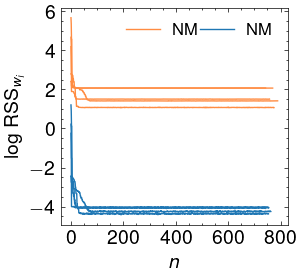

In [22]:
# Filter errors by method
nm_errors1 = [err['errors'] for err in all_errors1 if err['method'] == 'Nelder-Mead']
nm_errors2 = [err['errors'] for err in all_errors2 if err['method'] == 'Nelder-Mead']

#powell_errors = [err['errors'] for err in all_errors if err['method'] == 'Powell']
#lbfgsb_errors = [err['errors'] for err in all_errors if err['method'] == 'L-BFGS-B']

# Configure the Figure
plt.figure(figsize=(3, 2.75), constrained_layout=True)

# Plot errors for Nelder-Mead runs
for i, error_list in enumerate(nm_errors1):
    plt.plot(
        np.log10(error_list), 
        '-', 
        markersize=4,
        color='#FF8C42',               # Orange for Nelder-Mead
        label='NM' if i == 0 else ""  # Label only the first run
    )

# Plot errors for Nelder-Mead runs
for i, error_list in enumerate(nm_errors2):
    plt.plot(
        np.log10(error_list), 
        '-', 
        markersize=4,
        color='#1F77B4',               # Orange for Nelder-Mead
        label='NM' if i == 0 else ""  # Label only the first run
    )

# Plot errors for L-BFGS-B runs
#for i, error_list in enumerate(lbfgsb_errors):
#    plt.plot(
#        np.log10(error_list), 
#        '-',                         # Dashed line for L-BFGS-B
#        markersize=4,
#        color='#1F77B4',              # Blue for L-BFGS-B
#        label='L-BFGS-B' if i == 0 else ""     # Label only the first run
#    )

# Plot Initial Sobol Samples
#plt.plot(
#    iterations[:n_initial_points], 
#    neg_objective_values[:n_initial_points], 
#    'o', 
#    markersize=8, 
#    label='Sobol', 
#    color='#89BFA9'
#)

# Plot EI Samples
#plt.plot(
#    iterations[n_initial_points:], 
#    neg_objective_values[n_initial_points:], 
#    'o', 
#    markersize=8, 
#    label='logEI', 
#    color='#60568A'
#)


# Customize Plot Appearance
#plt.xlim(0, 120)                                          # Set x-axis limit
#plt.ylim(-0, 5)                                        # Uncomment and set y-axis limit if needed
plt.xlabel('$n$', fontsize=14)                            # X-axis label
plt.ylabel('$\\log$ RSS$_{w_{i}}$', fontsize=14)           # Y-axis label
plt.xticks(fontsize=14)                                   # X-axis tick label size
plt.yticks(fontsize=14)                                   # Y-axis tick label size
plt.legend(fontsize=12, loc="upper right", ncols=2, columnspacing=0.1, 
           #bbox_to_anchor=(1.05, 1)
          )                       # Display legend

# Display the Plot
#plt.savefig("fig_ei_relaxation_liquidfoam_comparison.pdf")                    # Uncomment to save the plot
plt.show()

Best Nelder-Mead Parameters obj1: [4.94037536 5.51937929 0.63333403]
Best Nelder-Mead Function Value obj1: 11.518673794203405
Best Nelder-Mead Parameters obj2: [5.42662757 5.60716829 0.8716221 ]
Best Nelder-Mead Function Value obj2: 3.792686694070766e-05


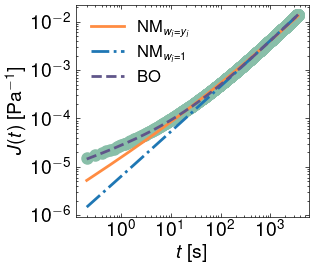

In [25]:
# Find the best results for Nelder-Mead and L-BFGS-B
nm_results1 = [res['result'] for res in results1 if res['method'] == 'Nelder-Mead']
nm_results2 = [res['result'] for res in results2 if res['method'] == 'Nelder-Mead']

# Identify the best (lowest function value) result for each method
best_nm_result1 = min(nm_results1, key=lambda r: r.fun)
best_nm_result2 = min(nm_results2, key=lambda r: r.fun)

# Extract optimized parameters and function values
best_nm_params1 = best_nm_result1.x
best_nm_params2 = best_nm_result2.x

best_nm_value1 = best_nm_result1.fun
best_nm_value2 = best_nm_result2.fun

# Print best results
print("Best Nelder-Mead Parameters obj1:", best_nm_params1)
print("Best Nelder-Mead Function Value obj1:", best_nm_value1)

# Print best results
print("Best Nelder-Mead Parameters obj2:", best_nm_params2)
print("Best Nelder-Mead Function Value obj2:", best_nm_value2)

# Compute model outputs for both best parameter sets
nm_model_values1 = evaluator.compute_model(
    (10**best_nm_params1[0], 10**best_nm_params1[1], best_nm_params1[2]), time
)

nm_model_values2 = evaluator.compute_model(
    (10**best_nm_params2[0], 10**best_nm_params2[1], best_nm_params2[2]), time
)

# Plot the data
plt.figure(figsize=(3, 2.75))

# Experimental data
plt.plot(time, y_true, 'o', markersize=8, color='#89BFA9')

# Nelder-Mead solution
plt.plot(time, nm_model_values1, '-', color='#FF8C42', lw=2, label='NM$_{w_{i}=y_{i}}$')

plt.plot(time, nm_model_values2, '-.', color='#1F77B4', lw=2, label='NM$_{w_{i}=1}$')


# L-BFGS-B solution
#plt.plot(time, lbfgsb_model_values, '-', color='#1F77B4', lw=2, label='L-BFGS-B')

# BO solution
plt.plot(time, bo_model_values, '--', color='#60568A', lw=2, label='BO')   # BO model fit


# Configure the plot
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$t$ [s]', fontsize=14)
plt.ylabel('$J(t)$ [Pa$^{-1}$]', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12, loc="best")

# Display the plot
plt.savefig("fig_mobo_fit_creep_data_ps_comparison.pdf")  # Uncomment to save the plot
plt.show()